# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

#### Notes: NLP High-level Steps

* normalize - lowercase and remove punctuations
* tokenize
* remove stop words
* lemmatize / stem

* feature extraction
    * bag of words - corpus
        * limitation: treats each word as equally important
        * collect all words
        * count of each word occurrence - document-term matrix
        * each count represented as term frequency in each document - compare document-term frequency
        * can calculate dot product of two row vectors; greater the dot product more similar
        * better similarity calculation is cosine similarity; range between -1 and 1
    * TF-IDF
        * count number of documents; document frequency
        * use document frequency and divide term frequencies by the document frequency of those terms
        * this gives us a metric that is proportional to the frequency of occurrence of a term in a document, but inversely proportional to the number of documents it appears in
        * it highlights the words that are more unique to a document, and thus better characterizing it
        * tf-idf = product of two weights = term frequency * inverse document frequency; give weights to words


In [1]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/dlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier

In [4]:
# load data from database
engine = create_engine('sqlite:///UdacityDisasterResponse.db')
df = pd.read_sql_table('messages', engine)

# remove rows with 2's under related column before split into X and y
df = df[df.related != 2]

X = df['message']
y = df.iloc[:, 4:]

print(X.shape)
print(y.shape)

(26028,)
(26028, 36)


In [5]:
df.groupby('genre')['message'].count()

genre
direct    10634
news      13036
social     2358
Name: message, dtype: int64

In [6]:
df.groupby('genre')['message'].count().index

Index(['direct', 'news', 'social'], dtype='object', name='genre')

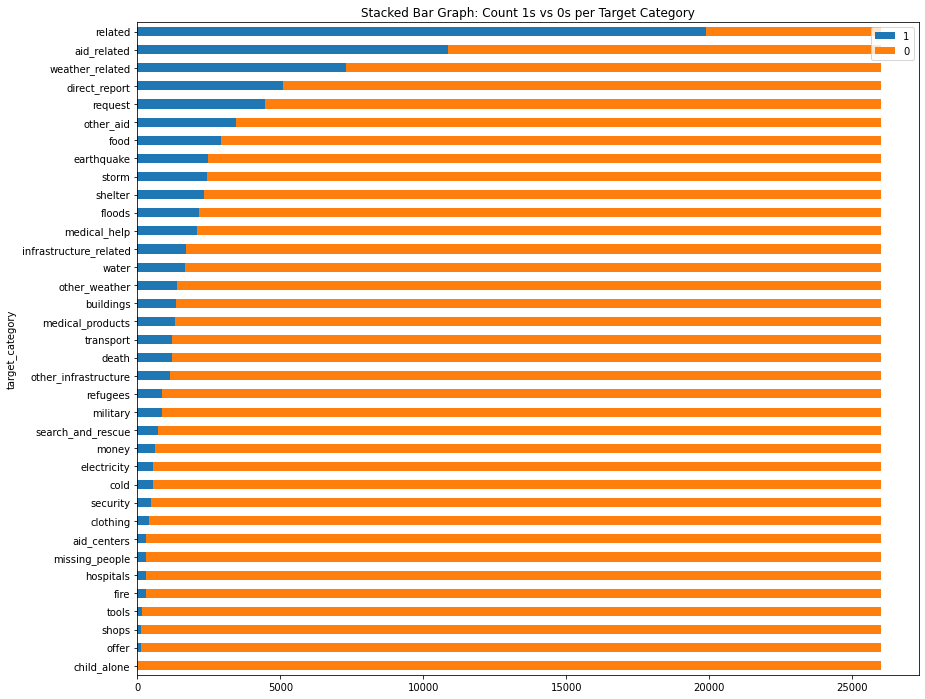

In [7]:
cnt_1 = []
cnt_0 = []
row_cnt = y.shape[0]

for column in y.columns:
    count_of_ones = y[column].sum()
    cnt_1.append(count_of_ones)
    count_of_zeros = row_cnt - count_of_ones
    cnt_0.append(count_of_zeros)
    
df_target = pd.DataFrame({'1': cnt_1, '0': cnt_0})
df_target.index = y.columns
df_target = df_target.reset_index().rename(columns={'index': 'target_category'})
df_target = df_target.sort_values(by='1')

# plot target categories: stacked bars of 1s vs 0s
df_target.plot(
  x = 'target_category', 
  kind = 'barh', 
  stacked = True, 
  title = 'Stacked Bar Graph: Count 1s vs 0s per Target Category', 
  figsize=(14, 12));

In [16]:
# https://plotly.com/python/bar-charts/
import plotly.express as px

cnt_1 = []
cnt_0 = []
row_cnt = y.shape[0]

for column in y.columns:
    count_of_ones = y[column].sum()
    cnt_1.append(count_of_ones)
    count_of_zeros = row_cnt - count_of_ones
    cnt_0.append(count_of_zeros)
    
df_target = pd.DataFrame({'1': cnt_1, '0': cnt_0})
df_target.index = y.columns
df_target = df_target.reset_index().rename(columns={'index': 'target_category'})
df_target = df_target.sort_values(by='1')

fig = px.bar(df_target, 
             x=["1", "0"], 
             y="target_category", 
             title="Stacked Bar Graph: Count 1s vs 0s per Target Category",
             orientation="h"
            )

fig.show()

### 2. Write a tokenization function to process your text data

In [ ]:
def tokenize(text):
    """
    Returns clean tokenized and lemmatized words
    
        Parameters:
            text (str): Text message which needs to be tokenized
            
        Returns:
            clean_tokens (list): List of tokens extracted from the provided text
    """
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    # identify urls
    detected_urls = re.findall(url_regex, text)
    
    # replace urls
    for detected_url in detected_urls:
        text = text.replace(detected_url, "urlplaceholder")

    # extract word tokens from provided text
    tokens = nltk.word_tokenize(text)
    
    # lemmanitize by removing inflectional and derivationally related forms of a word
    lemmatizer = nltk.WordNetLemmatizer()

    # list of cleaned tokens
    clean_tokens = [lemmatizer.lemmatize(w).lower().strip() for w in tokens]
    
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [ ]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    # Custom Class: extract the starting verb of a sentence; feature engineering step
    def starting_verb(self, text):
        # tokenize by sentences
        sentence_list = nltk.sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            pos_tags = nltk.pos_tag(tokenize(sentence))
            
            # index pos_tags to get the first word and part of speech tag
            first_word, first_tag = pos_tags[0]

            # return true if the first word is an appropriate verb or RT for retweet
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [ ]:
pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transformer', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline_fit = pipeline.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
y_pred_test = pipeline_fit.predict(X_test)
print(classification_report(y_test.values, y_pred_test, target_names=y.columns.values))

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
for key_name in pipeline.get_params().keys():
    print(key_name)

#### Parameters defined in lecture
```python
parameters = {
    'features__text_pipeline__count_vectorizer__ngram_range': ((1, 1), (1, 2)),
    'features__text_pipeline__count_vectorizer__max_df': (0.5, 0.75, 1.0),
    'features__text_pipeline__count_vectorizer__max_features': (None, 5000, 10000),
    'features__text_pipeline__tfidf_transformer__use_idf': (True, False),
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__min_samples_split': [2, 3, 4],
    'features__transformer_weights': (
       {'text_pipeline': 1, 'starting_verb': 0.5},
       {'text_pipeline': 0.5, 'starting_verb': 1},
       {'text_pipeline': 0.8, 'starting_verb': 1},
    )
}
```

In [ ]:
%%time 

parameters = {
    'features__text_pipeline__count_vectorizer__max_df': (0.5, 0.75, 1.0),
    'clf__estimator__min_samples_split': [2, 3, 4],
}

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=5)
cv.fit(X_train, y_train)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred_test_cv = cv.predict(X_test)
print(classification_report(y_test.values, y_pred_test_cv, target_names=y.columns.values))

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
pipeline_v2 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
                ('tfidf_transformer', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', MultiOutputClassifier(KNeighborsClassifier()))
    ])

In [ ]:
pipeline_knc = pipeline_v2.fit(X_train, y_train)
y_pred_test_knc = pipeline_knc.predict(X_test)
print(classification_report(y_test.values, y_pred_test_knc, target_names=y.columns.values))

### 9. Export your model as a pickle file

In [ ]:
file_name = "nlp_multi_classifier.pickle"
with open(file_name, 'wb') as pickle_file:
    pickle.dump(cv, pickle_file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

## Appendix

#### Lesson 4.17 Machine Learning Pipeline: case study - create custom transformer 

```python
def load_data():
    df = pd.read_csv('corporate_messaging.csv', encoding='latin-1')
    df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')]
    X = df.text.values
    y = df.category.values
    return X, y


def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def model_pipeline():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', RandomForestClassifier())
    ])

    return pipeline


def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)


def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = model_pipeline()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(y_test, y_pred)

main()
```

#### This is an example from Lession 4.22 using GridSearch and preventing data leakage using Sklearn's pipeline.

```python
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)


def load_data():
    df = pd.read_csv('corporate_messaging.csv', encoding='latin-1')
    df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')]
    X = df.text.values
    y = df.category.values
    return X, y


def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens


def build_model():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', RandomForestClassifier())
    ])

    parameters = {
        'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
        'features__text_pipeline__vect__max_features': (None, 5000, 10000),
        'features__text_pipeline__tfidf__use_idf': (True, False),
        'clf__n_estimators': [50, 100, 200],
        'clf__min_samples_split': [2, 3, 4],
        'features__transformer_weights': (
            {'text_pipeline': 1, 'starting_verb': 0.5},
            {'text_pipeline': 0.5, 'starting_verb': 1},
            {'text_pipeline': 0.8, 'starting_verb': 1},
        )
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)

    return cv


def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)


def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = build_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(model, y_test, y_pred)

main()
```